In [1]:
## Essential imports
import glob
import os
from datetime import datetime
import numpy as np
import joblib
import cv2
import json
from matplotlib import pyplot as plt
import copy 
from skimage.feature import hog
from sklearn.svm import LinearSVC
from skimage.transform import pyramid_gaussian
from imutils.object_detection import non_max_suppression


In [2]:
class SvmTrainer():
    def __init__(self):
        ## Default values
        print(f"Staring the Classifier")
        self.train_data=[]
        self.train_labels=[]
        self.classifier=LinearSVC()
    
    def load_train_data(self,file_path,data_type="*.png",data_class=1):
        '''
        Load the images from the filepath and get the HoG featues
        If dataclass=1 positive images 
        If dataclass=0 negative images
        '''
        files_found=False
        for filename in glob.glob(os.path.join(file_path,data_type)):
            files_found=True
            current_image=cv2.imread(filename)
            current_image=cv2.resize(current_image,(64,128))
            cv2.imshow("test",current_image)
            current_image=cv2.cvtColor(current_image,cv2.COLOR_BGR2GRAY)
            hog_features=hog(image=current_image,orientations=9,pixels_per_cell=(8,8),visualize=False,cells_per_block=(3,3))
            self.train_data.append(hog_features)
            self.train_labels.append(data_class)
            
        if files_found:
            print(f" HoG Feature extractor complete")
        else:
            raise Exception("No such file or folder")
            
    def train_svm(self,model_save_path="./"):
        '''
        This function calls for training the data set
        '''
        ## Asserts if there are training data
        assert len(self.train_data)>0,f"No training data available"
        # Convert to numpy arrays
        self.train_data = np.float32(self.train_data)
        self.train_labels= np.array(self.train_labels)
        #Fitting the data
        self.classifier.fit(self.train_data,self.train_labels)
        print(f"Training complete saving model at {model_save_path}")
        now = datetime.now()
        # dd/mm/YY H:M:S
        dt_string = now.strftime("%d_%m_%Y_%H_%M_%S")
        model_name=model_save_path+"svm_model_"+dt_string+".dat"
        joblib.dump(self.classifier,model_name)
        print(f"Model saved as at {model_name}")
        
    
        
        



In [3]:
class PersonDetecor():
    def __init__(self,path_test: str,path_anno: str,model_path:str)-> None:
        '''
        Initiate the person detector class
        
        Params
        ----------
        path_test : Relative file path with the test images
        path_anno : Relative path with the annotations 
        '''
        self.path_test=path_test
        self.path_anno=path_anno
        self.downscale_factor=1.5
        self.classifier=joblib.load(model_path)
        # Size of the detections used in training 
        self.detect_size=(64,128)
        self.step_size=(10,10)
        ## The confusion matrix
        ## TP,FP | FN , TN
        self.CM=[[0,0],[0,0]]
        
        
        
    def nms(self):
        '''
        Fast Non-maximum-supression method based on Malisiewicz et al 
                    
        
        
        References:
        The https://github.com/quantombone/exemplarsvm
        https://learnopencv.com/non-maximum-suppression-theory-and-implementation-in-pytorch/
        https://pyimagesearch.com/2015/02/16/faster-non-maximum-suppression-python/
        https://nms.readthedocs.io/en/latest/_modules/nms/malisiewicz.html
        '''
        
        raise NotImplementedError("Please implement the method")
        
    def metrics(self,detections,ground_truths):
        '''
        Calculate the performance metrics of the method 
        
        Measure following metrics         
            meanAveragePrecision
            average IoU
            
            
        References:
        https://towardsdatascience.com/on-object-detection-metrics-with-worked-example-216f173ed31e
        https://www.v7labs.com/blog/mean-average-precision
        
        '''
        
        ##IOU calculation
        for detection in detections:            
            x_mid=detection[0]+detection[2]/2
            y_mid=detection[1]+detection[3]/2
        for gt in ground_truths:
            gt=0
            
        
        
        
        raise NotImplementedError("Implement me")
        
    def sliding_window(self,image,window_size,step_size):
        ''''
        Sliding window approach to pass throught the image
        
        Parameters
        ----------
        window_size: Tuple (1x2)
                    The size of the window
        
        step_size : Tuple(1x2)
                            
        
                        the size of the window that wil p 
        Returns
        -------
        x : ndarray, shape Q
        
        
        '''
        
        for y in range(0,image.shape[0]-window_size[1],step_size[1]):
            for x in range(0,image.shape[1]-window_size[0],step_size[0]):
                yield (x,y,image[y:y+window_size[1],x:x+window_size[0]])      
        
        
    def visualise(self,image,bBoxs,confidence):
        '''
        Visualise the result bBox on image
        '''
        
        for bBox in bBoxs:        
            cv2.rectangle(image,(bBox[0],bBox[1]),(bBox[2],bBox[3]),(0,0,255),2)
            # cv2.putText(image,"Confidence: "+str(confidence),(bBox[0],bBox[2]-10),cv2.FONT_HERSHEY_SIMPLEX,1,(0,255,0),2)
            # figsize=(25,10)
        figure1=plt.figure()
        ax1=figure1.add_subplot(111)
        ax1.imshow(image)
        ax1.set(title="Prediction",xlabel="X",ylabel="Y")     
        plt.show()
        
        
    def add_padding(self,image):
        '''
        Add padding to the edges if the image is not of the right shape
        
        '''
        
        top=0
        btm=0
        lft=0
        rht=0
        
        if ((image.shape[1])%(self.detect_size[0]) != 0):
            miss_pixels_x=image.shape[1]-(np.floor(image.shape[1]/self.detect_size[0])*self.detect_size[0])
            rht=miss_pixels_x
            
        if ((image.shape[1])%(self.detect_size[0]) != 0):
            miss_pixels_y=image.shape[0]-(np.floor(image.shape[0]/self.detect_size[1])*self.detect_size[1])
            btm=miss_pixels_y 
            

        
        return cv2.copyMakeBorder(image, top, btm, lft, rht, cv2.BORDER_CONSTANT, None, value = 0)

        
        
    
    def detect_persons_multi(self,data_type: str,metrics:bool=False,visualise:bool=False)-> None:
        '''
        Detect people in multiple images in a given folder 
        
        Parameters
        ----------
        
        data_type: string
                    the data type of images eg: png,jpeg
        metrics  : bool
                    Boolean to calculate metrics
        visualise : bool
                    Visualise the results
        
        '''
        
        
        
        for filename in glob.glob(os.path.join(self.path_test,data_type)):
            current_detections=[]
            current_scale=0
            current_image=cv2.imread(filename)
            ## Maybe resize the image
            
            for scaled_image in pyramid_gaussian(current_image):
                if scaled_image.shape[0]<self.detect_size[0] or scaled_image.shape[1]<self.detect_size[1]:
                    #Loop breaks when the the scale reaches smaller than the images
                    # that was used to train the classifier
                    break
                for (x,y,cropped_image) in sliding_window(scaled_image,self.detect_size,self.step_size):
                    #Convert to Grayscale for preprocessing
                    cropped_image=cv2.cvtColor(cropped_image,cv2.COLOR_BGR2GRAY)
                    #Create HoG features
                    hog_feature=hog(cropped_image,
                                orientations=9,
                                pixels_per_cell=(16, 16),
                                cells_per_block=(3, 3),
                                block_norm='L2-Hys',
                                visualize=False,
                                transform_sqrt=False,
                                feature_vector=True,
                                multichannel=None)
                    # Flatten the features
                    hog_feature=hog_feature.reshape(1,-1)
                    # Pass it through the trained model
                    prediction=self.classifier(hog_feature)
                    current_confidence=self.classifier.decision_function(hog_feature)
                    
                    ##If person is detected with a confidence over 50%
                    if (prediction==1) and (current_confidence>0.5):
                            x=int(x * (self.downscale_factor**current_scale))
                            y=int(y* (self.downscale_factor**current_scale))
                            w=int(self.detect_size[0]*(self.downscale_factor**current_scale))
                            h=int(self.detect_size[1]*(self.downscale_factor**current_scale))
                            current_detections.append(x,y,w,h,current_confidence)
                current_scale+=1
            #End of current image detections
            # If there are detections look work on the non max supression 
            if len(current_detections)>0:                
                bBoxs=np.array([[x,y,x+w,y+h] for (x,y,w,h,_) in current_detections])
                confidences=[conf for (_,_,_,_,conf) in current_detections]
                max_box=non_max_suppression(bBoxs,probs=confidences,overlapThresh=0.3)

                
    def detect_persons_single(self,file_name: str,metrics:bool=False,visualise:bool=False)-> None:
        '''
        Detect people in a single image

        Parameters
        ----------

        data_type: string
                    the data type of images eg: png,jpeg
        metrics  : bool
                    Boolean to calculate metrics
        visualise : bool
                    Visualise the results

        '''



        filename =os.path.join(self.path_test,file_name)
        current_detections=[]
        current_scale=0
        current_image=cv2.imread(filename)
        current_image=cv2.cvtColor(current_image,cv2.COLOR_BGR2RGB)
        
        current_image=cv2.resize(current_image,(400,256))
 

        for scaled_image in pyramid_gaussian(current_image,downscale=self.downscale_factor):
            if scaled_image.shape[0]<self.detect_size[0] or scaled_image.shape[1]<self.detect_size[1]:
                #Loop breaks when the the scale reaches smaller than the images
                # that was used to train the classifier
                break
            for (x,y,cropped_image) in self.sliding_window(scaled_image,self.detect_size,self.step_size):      
                hog_feature=hog(cropped_image,
                            orientations=9,
                            pixels_per_cell=(8, 8),
                            cells_per_block=(3, 3))
                # Flatten the features
                
                hog_feature=hog_feature.reshape(1,-1)
                # Pass it through the trained model
                try:
                    prediction=self.classifier.predict(hog_feature)
                except:                    
                    print(f"Error in prediction")
                    continue
                current_confidence=self.classifier.decision_function(hog_feature)

                ##If person is detected with a confidence over 50%
                if (prediction==1) and (current_confidence>0.5):
                        x=int(x * (self.downscale_factor**current_scale))
                        y=int(y* (self.downscale_factor**current_scale))
                        w=int(self.detect_size[0]*(self.downscale_factor**current_scale))
                        h=int(self.detect_size[1]*(self.downscale_factor**current_scale))
                        current_detections.append((x,y,w,h,current_confidence))
            current_scale+=1
        #End of current image detections
        # If there are detections look work on the non max supression 
        max_box=[]
        if len(current_detections)>0:                
            bBoxs=np.array([[x,y,x+w,y+h] for (x,y,w,h,_) in current_detections])
            confidences=np.array([conf[0] for (_,_,_,_,conf) in current_detections])
            max_box=non_max_suppression(bBoxs,probs=confidences,overlapThresh=0.5)
            

        if visualise and (len(max_box)>0):
            self.visualise(current_image,max_box,np.max(confidences))
        else:
            print(f"No humans found")

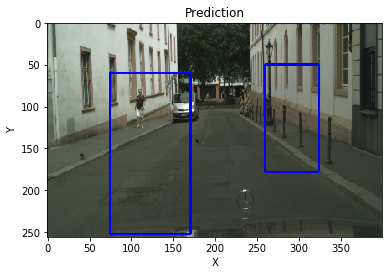

In [4]:
test_path="./data/rawdata/leftImg8bit/test/mainz"
# file_name="berlin_000122_000019_leftImg8bit.png"

file_name=['mainz_000001_044619_leftImg8bit.png','mainz_000001_041284_leftImg8bit.png','mainz_000001_041172_leftImg8bit.png']
path_cell_16="./data/models/svm_model_13_12_2022_17_45_22.dat"
path_cell_08="./data/models/svm_model_28_11_2022_22_54_16.dat"
path_cell_04="./data/models/svm_model_13_12_2022_17_54_46.dat"
svm_classifier=PersonDetecor(path_test=test_path,path_anno="",model_path=path_cell_08)
svm_classifier.detect_persons_single(file_name=file_name[2],visualise=True)

